# Pore and Surface Diffusion Model (PSDM)

Originally developed by Michigan Technological University, coded in Python by USEPA

This can be used to model granular activated carbon (GAC) systems.

# 5.2 Example modelling of compound TCE

author: Jonathan Burkhardt @UCChEJBB,
         Levi Haupert

In [1]:
## Import Required Packages
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import pylab as plt

import os
srt_dir = os.getcwd()

import PSDM
os.chdir(srt_dir)

## Files

This example uses "Example_TCE.xlsx" as its input file. 

Sheet "Properties" has chemical properties of compounds you wish to model. You can have more compounds in your Properties sheet than the model needs, so it may be helpful to create a standard sheet for numerous projects. 

Sheet "Kdata" has K [(ug/g)(L/ug)^(1/n)] & 1/n (unitless) information. 'brk' stores the days to complete breakthrough. 'q' is solid phase concentration (ug/g). 'AveC' is the average concentration (ug/L). This information can be calculated by the model for fitting data, but this provides a mechanism for storing/inputing these values for some simulations. 

Sheet "data" has a data structure for ['type', 'time', 'concentration', 'compound']. Where type corresponds to where samples were taken (e.g., 'influent', 'effluent'). 'Time' is numeric and should the maximum value determines the lengh of simulations (The units of 'Time' are listed in the "columnSpecs" sheet). 'Concentration' units are also listed in "columnSpecs". 'Compounds' should match those in "Properties", and should provide information for both influent and effluent data. 

Sheet "columnSpecs" has column information. 

An example of reading in these sheets is shown below.



In [2]:
# =============================================================================
# Define the File to analyze
# can be in different folder, must be explicit for file location or can 
# use referential convention '../data/filename.xlsx' or 'C:/folders.../filename'
# =============================================================================
fn = 'Example_TCE.xlsx'

# =============================================================================
# READ IN Chemical Property Information
# may need to change location of file, depending on where it is stored locally
# properties are included in 'fn' from above, but can be separate file as well
# =============================================================================
chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

# =============================================================================
# Read in Input File
# Can change location of data_sheet= and column_sheet= to match file naming
# =============================================================================
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

# Example 1: Simple, no fouling

    chem_type = 'halogenated alkenes' #omitted, see Example 2 for how to use
    water_type = 'Organic Free'       #omitted, see Example 2 for how to use
    nr = radial collocation points
    nz = axial collocation points
    k_data = pandas dataframe containing K & 1/n data (ug/g)(L/ug)^(1/n) expected

Trichloroethylene
EBCT:  9.4  min


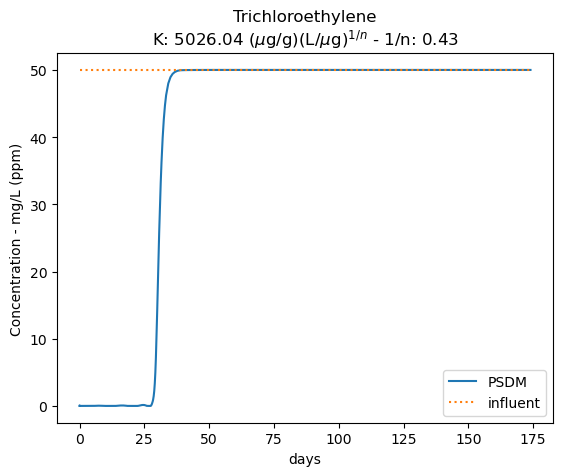

In [3]:
for comp in compounds:
    print(comp)
    
    # SETTING UP PSDM simulation column
    column = PSDM.PSDM(column_info[carbons[0]], 
                   chem_data, 
                   raw_data,
                   nr=8,
                   nz=12, 
                   k_data=k_data,\
                   optimize=False
                   )
    
    print('EBCT: ', np.round(column.ebct, 2), ' min') 
    column.test_range = np.array([k_data[comp]['K']]) 
    column.xn_range = np.array([k_data[comp]['1/n']])
    
    # RUNNING the simulation
    # only results is used in this example
    _compound, _k, _xn, _ssqs, results = column.run_psdm_kfit(comp)
    
    ### plotting results 
    # units are converted from ug/L to mg/L 
    plt.plot(results.index, 
             results.values/1000., 
             label='PSDM')
    (raw_data[column.influent][comp]/1000.).plot.line(label='influent',linestyle=':')
    
    # Plot Labels, etc.
    plt.legend()
    plt.title(comp+'\nK: '+repr(round(_k,2))+' ($\mu$g/g)(L/$\mu$g)$^{1/n}$ - 1/n: '+repr(round(_xn,3)))
    plt.xlabel(column_info[carbons[0]]['time'])
    plt.ylabel('Concentration - mg/L (ppm)')
    plt.savefig(comp+'_'+carbons[0]+'_example1.png', dpi=300)
    
    
    tab2 = 'model-'+comp
    ## Set up file to write output
    with pd.ExcelWriter('Example_TCE_' + carbons[0] + '_example1.xlsx') as writer:
        results.to_excel(writer, sheet_name=tab2)

